In [15]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt 
import seaborn as sns
from arch.__future__ import reindexing
import statsmodels.api as sm

from arch import arch_model

plt.style.use('bmh')

# Dataset

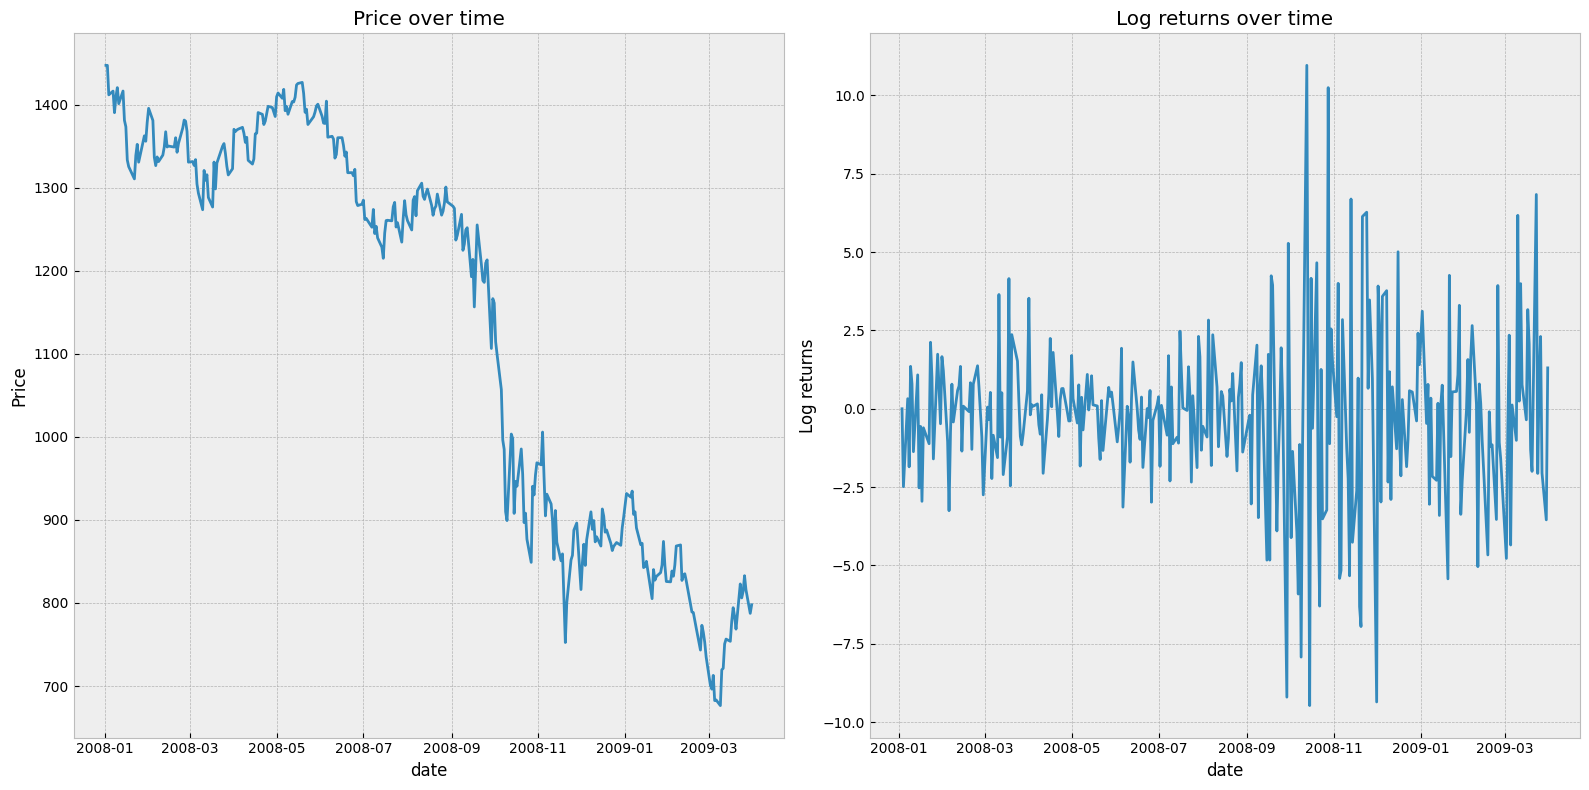

In [30]:
df = pd.read_csv('spx-daily-returns.csv')
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d-%b-%y')

# Select the rows between 02 january 2008 and april 01 2009
start_date = '2008-01-02'
end_date = '2009-03-31'

mask = (df['date'] >= start_date) & (df['date'] <= end_date)
df = df.loc[mask]

# Calculate log returns and add it as a new column
df['log_returns'] = 100* np.log(df['close'] / df['close'].shift(1))
Y = df["log_returns"].values[1:]

# Create a 1x2 subplot
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
# Plot 'close' on the first subplot
sns.lineplot(x='date', y='close', data=df, ax=ax[0])
ax[0].set_title('Price over time')
ax[0].set_ylabel('Price')

# Plot 'log_returns' on the second subplot
sns.lineplot(x='date', y='log_returns', data=df, ax=ax[1])
ax[1].set_title('Log returns over time')
ax[1].set_ylabel('Log returns')

plt.tight_layout()
plt.show()

# GARCH for volatility

In [12]:
# Ajuster le modèle GARCH
GARCH_MODEL = arch_model(Y, vol='Garch', p=1, q=1)
results = GARCH_MODEL.fit()

# Effectuer des prévisions de la volatilité future
forecast_horizon = 5  # Nombre de périodes de prévision
forecasts = results.forecast(start=0, horizon=forecast_horizon)

# Afficher les prévisions de volatilité
forecasted_volatility = np.sqrt(forecasts.variance.iloc[-1, :])
print("Prévisions de volatilité future :")
print(forecasted_volatility)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3777564968.8128695
Iteration:      2,   Func. Count:     13,   Neg. LLF: 28072.392342346495
Iteration:      3,   Func. Count:     20,   Neg. LLF: 877.2793778280566
Iteration:      4,   Func. Count:     28,   Neg. LLF: 679.9604088373172
Iteration:      5,   Func. Count:     34,   Neg. LLF: 676.6748862771423
Iteration:      6,   Func. Count:     39,   Neg. LLF: 676.6347399001307
Iteration:      7,   Func. Count:     45,   Neg. LLF: 676.456088564001
Iteration:      8,   Func. Count:     51,   Neg. LLF: 676.3244680368974
Iteration:      9,   Func. Count:     56,   Neg. LLF: 676.3228598524486
Iteration:     10,   Func. Count:     61,   Neg. LLF: 676.3228573892136
Iteration:     11,   Func. Count:     65,   Neg. LLF: 676.322857389195
Optimization terminated successfully    (Exit mode 0)
            Current function value: 676.3228573892136
            Iterations: 11
            Function evaluations: 65
            Gradient evaluations: 11

In [16]:
# Récupérer les résidus du modèle GARCH
residuals = results.resid / results.conditional_volatility

# Ajouter une constante aux résidus pour le test de White
residuals_with_const = sm.add_constant(residuals)

# Effectuer le test de White pour l'hétéroscédasticité conditionnelle
white_test = sm.stats.diagnostic.het_white(residuals**2, residuals_with_const)
print("Résultats du test de White (Hétéroscédasticité conditionnelle) :")
print("LM Statistic:", white_test[0])
print("LM p-value:", white_test[1])

Résultats du test de White (Hétéroscédasticité conditionnelle) :
LM Statistic: 248.30810318576087
LM p-value: 1.2038724813747063e-54


En d'autres termes, les résidus montrent une variation significative de la volatilité conditionnelle au fil du temps, ce qui est une caractéristique importante de nombreux modèles de volatilité financière.

Cela confirme que votre modèle GARCH est approprié pour modéliser la volatilité des rendements financiers du S&P 500, car il capture cette hétéroscédasticité conditionnelle. Vous pouvez maintenant utiliser en toute confiance les résultats de votre modèle GARCH pour prendre des décisions ou pour d'autres analyses financières.

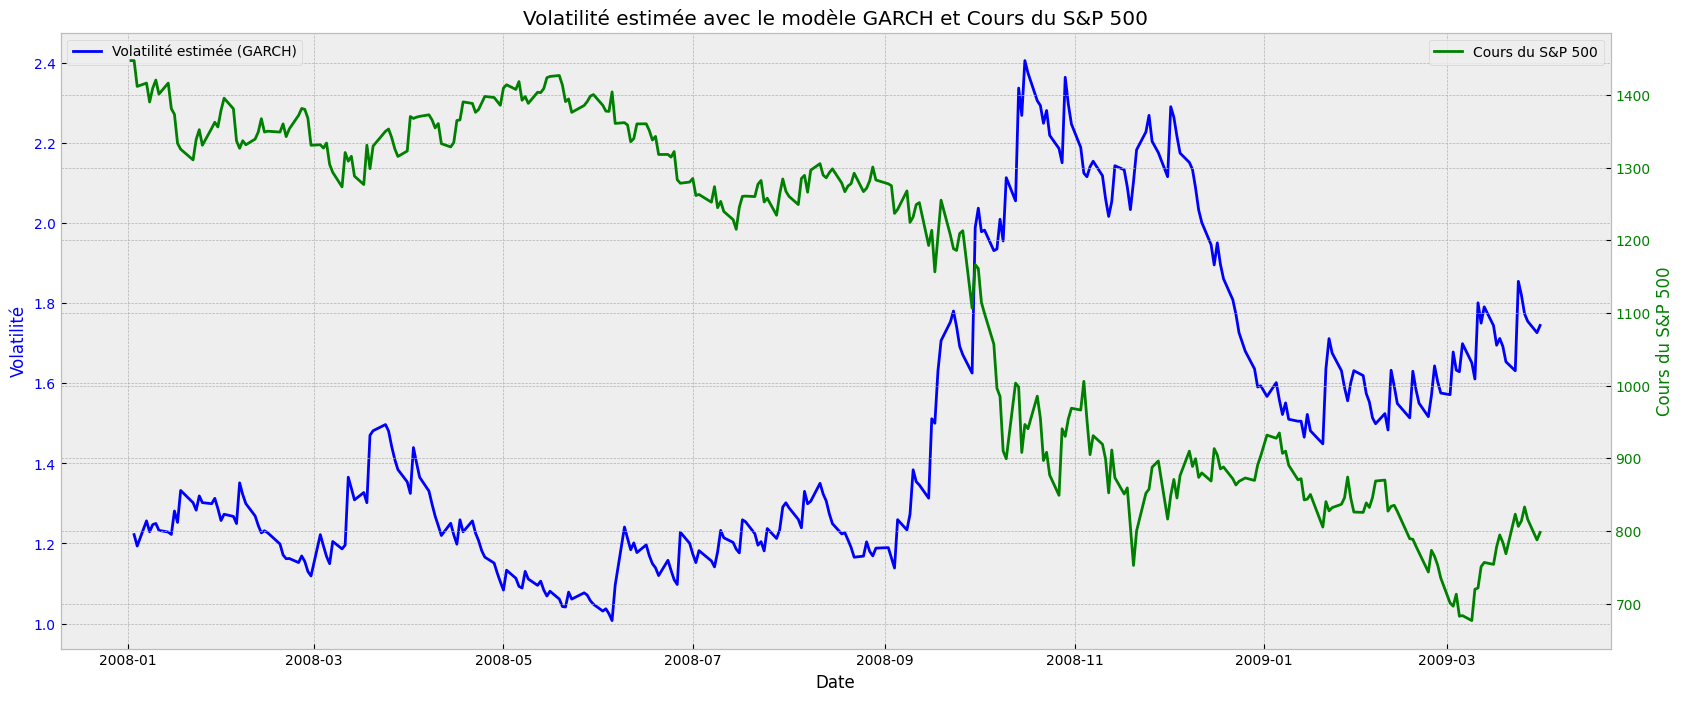

In [23]:
# Récupérer les résultats de la volatilité estimée
volatility_estimates = np.sqrt(results.conditional_volatility)

# Créer une figure et des axes partagés
fig, ax1 = plt.subplots(figsize=(20, 8))

# Tracer la volatilité estimée (à gauche)
ax1.plot(df['date'][1:], volatility_estimates, label='Volatilité estimée (GARCH)', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Volatilité', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# Créer un deuxième axe pour le cours du S&P 500 (à droite)
ax2 = ax1.twinx()
ax2.plot(df['date'], df['close'], label='Cours du S&P 500', color='green')
ax2.set_ylabel('Cours du S&P 500', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.title('Volatilité estimée avec le modèle GARCH et Cours du S&P 500')
plt.grid(True)
plt.show()


# ARMA-GARCH